# Tutorial on neuronal package

**names: Amelia Paine, Han Sae Jung**

## Motivation

Commonly, electrophysiological data is processed by a bandpass filter and a moving average. Afterwards, neuronal signals are detected by thresholding or template-based methods. Then, the peak amplitudes of the identified spikes are quantified by simply subtracting the peak of the signal from the baseline. While these methods are computationally effective and have become a standard protocol for analyzing electrophysiological data, they render phase distortions to the signals to a certain extent; hence, we lose some information about the signals along the way.

Our goal is to analyze these data in a more statistically rigorous manner. Starting with the generative model proposed by Merel et al. ($\textit{J. Neurosci Methods}$ **2016**), we will first infer the spike timings and peak amplitudes of postsynaptic potentials (PSP) in a Bayesian manner. Afterwards, we will modify the model in a way that accounts for action potentials (AP) as well. Additionally, we will work on resolving complications that arise from real electrophysiological data (e.g. varying baseline).

## Generative Model 

Our model is adapted/modified from the model suggested by Merel et al. ($\textit{J. Neurosci Methods}$ **2016**)

The simplest version of our model is the following:

$$y_t = \sum_{i=1}^{n} a_i f_i(t - t_i) + b + \epsilon_t$$

$$f_i(t) = (\exp^{-t / \tau_i^d} - \exp^{-t / \tau_i^r}) \: \text{for} \: t \ge 0$$ 

$$\epsilon_t = \sum_{j=1}^{p} \phi_j \epsilon_{t-j} + u_t , \: u_t \approx N(0, \sigma^2)$$ 

$\text{where}$ 

$y_t \equiv \text{observed voltage trace}$, 

$t_i \equiv \text{spike time of} \: i^{th} \: \text{PSP}$, 

$n \equiv \text{number of PSP's}$, 

$b \equiv \text{constant baseline}$, 

$f_i(t) \equiv \text{mathematical trial function of PSP}$, 

$\epsilon_t \equiv \text{general AR(p) autoregressive model of the noise}$, 

$u_t \equiv \text{Gaussian noise}$, $\tau_i^d \equiv \text{decay time constant}$, 

$\tau_i^r \equiv \text{rise time constant}$, 

$a_i \equiv \text{constant related to the peak amplitude of each PSP}$

By differentiating $f_i(t)$ with respect to $t$, we find that the maximum of the signal occurs at $t_i = t_i^*$:

$$t_i^* = \frac{ln(t_i^d / t_i^r)}{1 / t_i^r - 1 / t_i^d}$$

Then, 

$$a_i^{peak} = a_i \cdot f_i(t=t^*)$$

In order for our model to be successful, we need to somehow account for the following noise sources:

**examples of noise sources: electrical hardware, analog to digital conversion, membrane oscillations and local field potential from other neurons (not immediately adjacent to the electrode from which we are measuring), solution in which neurons are cultured, changes in resistance between the electrode and the interior of the neuron**

Since our noise is a mixture of a wide range of sources, we can argue that Gaussian i.i.d. noise model can be valid (on the basis of central limit theorem) to a certain extent. However, for a more accurate description of the noise process, we will account for the correlations in the noise by modeling the noise as a autoregressive AR(p) process. 

For AR(0) case (Gaussian i.i.d. noise), our likelihood function is:

$$ p(Y|\Theta) = \prod_{t=1}^{T} \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(y_t-\hat{y_t})^2}{2\sigma^2}\right)$$

where $\hat{y_t}$ refers to the predicted noiseless trace:

$$\hat{y_t} = \sum_{i=1}^{n} a_i f_i(t - t_i) + b$$

We can extend this to a more general AR(p) case:

$$ p(Y|\Theta) = \prod_{t=1}^{T} \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(y_t-\hat{y}_{t|t-1})^2}{2\sigma^2}\right)$$

where $\hat{y}_{t|t-1}$ is:

$$\hat{y}_{t|t-1} = \hat{y_t} + \sum_{j=1}^{p} \phi_j (y_{t-j} - \hat{y}_{t-j})$$

Given this model, the likelihood function is:

$$L(\Theta|Y) \propto ln p(Y|\Theta) \: + \: ln p(\Theta)$$

This model is too simplistic because it does not account for action potentials; neuronal signals can be either action potentials or postsynaptic potentials. Also, there is usally a varying, periodic baseline. 

We will modify this simple model further to account for action potentials and the varying, periodic baseline. But for now, as a minimum (but still nontrivial) test of our simple generative model, we will perform parameter estimation using pymc3 on a single PSP signal with reasonably flat baseline by assuming AR(0) noise process (aka i.i.d. Gaussian noise).

In [6]:
#Standard imports
%matplotlib inline

import theano.tensor as tt
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
#The function behind the scenes in neuronal.psp_fit

def psp_fit(x, y, nsamples, initial_guess, plot=True):
    """
    Uses pymc3 to calculate the trace for the PSP model. In this particular model, we assume a single PSP peak and
    a constant baseline.
    
    Parameters
    ----------
    x : array
        Input time data in seconds
    y : array
        Input voltage data in mV
    nsamples : integer
        Number of samples for pymc3 calculation
    initial_guess : dictionary
        Dictionary of initial guesses for the parameters of the model
    plot : boolean
        Plots of the marginal distributions of the estimated parameters (plotted when True)
    """
    with pm.Model() as PSP_model:
        b = pm.Flat('b')
        sigma = pm.HalfFlat('sigma')
        a1 = pm.Flat('a1')
        t1 = pm.Uniform('t1', lower=np.min(x), upper=np.max(x))
        tau_d1 = pm.Uniform('tau_d1', lower=0, upper=0.1)
        tau_r1 = pm.Uniform('tau_r1', lower=0, upper=0.1)
        
        model = (x >= t1) * a1 * (tt.exp(-(x-t1) / tau_d1) - tt.exp(-(x-t1) / tau_r1)) + b
        loglike = pm.Normal.dist(mu=model, sd=sigma).logp(y)
        pm.Potential('result', loglike)
        
        trace=pm.sample(nsamples, cores=2, start=initial_guess)

    if plot:
        pm.traceplot(trace)
    return trace

Let's import the data using the loadtxt function from the neuronal package (which makes use of np.loadtxt())

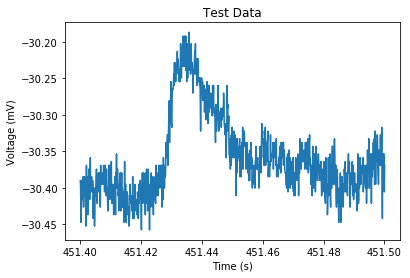

In [9]:
#our package import
import neuronal

test_data = neuronal.loadtxt('neuronal/data/single_PSP_data.txt')

#1st row corresponds to Time (s), 2nd row corresponds to Voltage (mV)
x = test_data[0, :]
y = test_data[1, :]

#Plot the data to guess the parameters
plt.plot(x, y)
plt.title('Test Data')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_r1, tau_d1, t1, a1, sigma, b]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:46<00:00, 107.45draws/s]
The acceptance probability does not match the target. It is 0.8929992799811458, but should be close to 0.8. Try to increase the number of tuning steps.


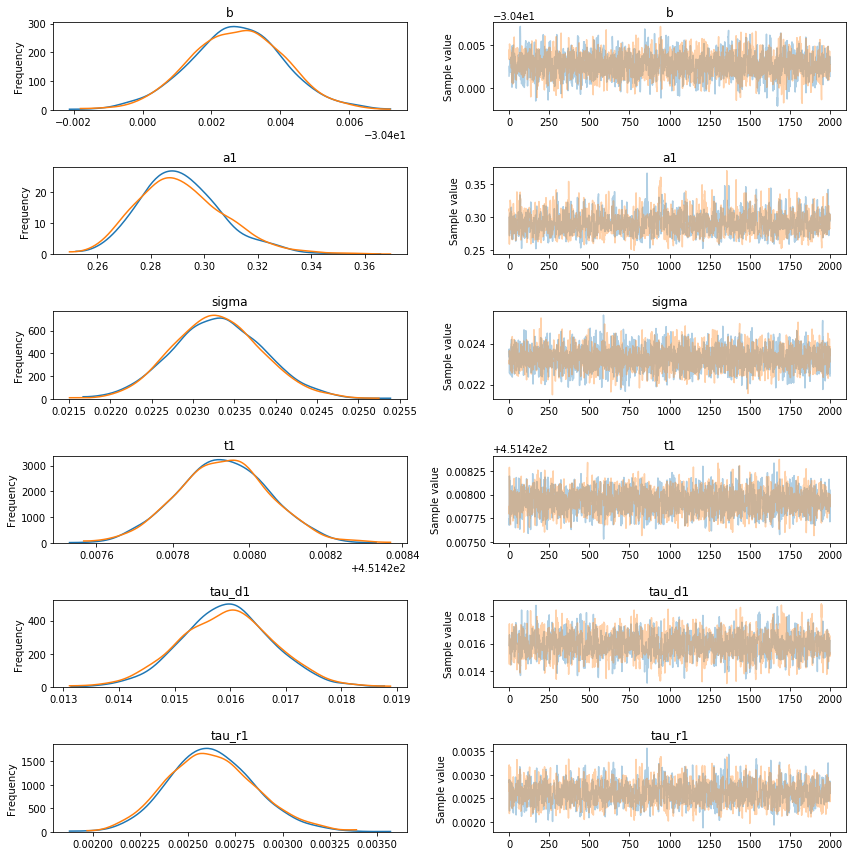

In [10]:
#Perform parameter estimation
initial_guess = {'b': -30.39, 'a1': 0.3, 't1': 451.43, 'tau_d1': 0.01, 'tau_r1': 0.001}
sample = neuronal.psp_fit(x, y, 2000, initial_guess)

In [11]:
summary = pm.summary(sample)
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b,-30.397286,0.001364,0.000033,-30.399880,-30.394480,1732.351400,0.999791
a1,0.291371,0.016045,0.000428,0.262415,0.324116,1225.450442,0.999788
sigma,0.023293,0.000538,0.000010,0.022227,0.024346,2569.797509,0.999954
t1,451.427931,0.000119,0.000003,451.427711,451.428174,2471.497575,0.999795
tau_d1,0.015927,0.000846,0.000022,0.014243,0.017552,1310.389040,0.999792
tau_r1,0.002624,0.000227,0.000006,0.002171,0.003068,1345.377195,0.999776


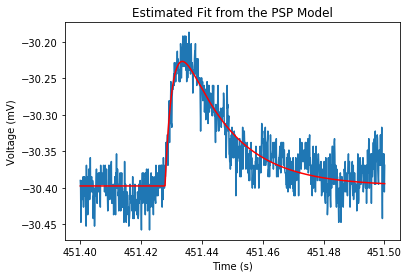

In [12]:
#plot the estimated fit and the data together
b, a1, sigma, t1, tau_d1, tau_r1 = summary['mean']
PSP_model = (x >= t1) * a1 * (np.exp(-(x-t1) / tau_d1) - np.exp(-(x-t1) / tau_r1)) + b

plt.plot(x, y)
plt.plot(x, PSP_model, c='r')
plt.title('Estimated Fit from the PSP Model')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

It appears like our simplest model works when the baseline is reasonably flat and when the only signal present is a PSP signal.